In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image 
import io 
import tensorflow as tf 
from tensorflow.keras.applications import MobileNetV2
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from sklearn.model_selection import train_test_split
from functools import reduce
from functions import prepare_image, extract_features
import os
from tqdm import tqdm
from scipy.spatial.distance import cosine

In [2]:
# !pip install tqdm

In [3]:
json_file_name = os.listdir('metadata')

In [4]:
json_file_name
hashtags = [hashtag[:-5] for hashtag in json_file_name]

In [5]:
non_hashtags = ['.DS_', '.ipynb_checkp']

In [6]:
for non_hashtag in non_hashtags:
    try:
        hashtags.remove(non_hashtag)
    except:
        pass # If we can't remove it, it's already gone

In [7]:
hashtags

['fitness',
 'selfie',
 'travel',
 'nature',
 'babies',
 'cars',
 'food',
 'architecture',
 'animals',
 'wedding']

In [8]:
hashtag_metadata = []
for hashtag in hashtags: 
    hashtag_metadata.append(pd.read_json(f'metadata/{hashtag}.json'))
hashtag_metadata = reduce(lambda x, y: pd.concat([x, y]), hashtag_metadata)
pd.DataFrame.reset_index(hashtag_metadata, drop=True, inplace=True)
hashtag_metadata.tail()

,post_link,image,search_hashtag,hashtags,image_local_name
995,https://www.instagram.com/p/CUo_2tMMk6U/,https://instagram.fbom26-1.fna.fbcdn.net/v/t51...,wedding,"[#ablekuma, #interiordeco, #wedding, #accra, #...",68b22103-07fb-4430-a649-a2e2ca2f21bc.jpg
996,https://www.instagram.com/p/CUo_2yos79o/,https://instagram.fbom26-1.fna.fbcdn.net/v/t51...,wedding,"[#designerweddingdress, #modernboho, #weddingi...",38ef531c-96df-465b-9f21-51993feaeb61.jpg
997,https://www.instagram.com/p/CUo_2kLMGyw/,https://instagram.fbom26-1.fna.fbcdn.net/v/t51...,wedding,"[#confettata, #wedding, #castellocernuscolomba...",3c67996b-2328-4d80-8728-04680d351e37.jpg
998,https://www.instagram.com/p/CUo_2nxrddD/,https://instagram.fbom26-1.fna.fbcdn.net/v/t51...,wedding,"[#wedding, #sony, #Photography, #SonyAlpha, #a...",f621df70-20ac-4f3e-a5a0-7b7abdea4253.jpg
999,https://www.instagram.com/p/CUo_2Mvjk2m/,https://instagram.fbom26-1.fna.fbcdn.net/v/t51...,wedding,"[#preweddingphoto, #wedding, #preweddingphotog...",b1a06d83-9b2b-4742-9ac7-ad2d167f8d50.jpg


In [9]:
hashtag_metadata = hashtag_metadata[hashtag_metadata['hashtags'].notna()]

In [10]:
all_hashtags = [hashtag for hashtags in hashtag_metadata['hashtags'] for hashtag in hashtags]
        

In [11]:
all_hashtags = sorted(list(set(all_hashtags)))

In [12]:
len(all_hashtags)

8080

In [13]:
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [14]:
hashtag_lookup

{'#ARCH': 0,
 '#ART': 1,
 '#AWPTcoach': 2,
 '#Aboutwomens': 3,
 '#Admission': 4,
 '#Adventure': 5,
 '#Aluminium': 6,
 '#AnimalWelfareDay': 7,
 '#Animali': 8,
 '#Animals': 9,
 '#Antalya': 10,
 '#Aquarium': 11,
 '#Art': 12,
 '#Asia': 13,
 '#Ausflug': 14,
 '#BGC': 15,
 '#BOSSMindset': 16,
 '#Babies': 17,
 '#BabiesofInstagram': 18,
 '#Baby': 19,
 '#BabyBlog': 20,
 '#BabyBoy': 21,
 '#BabyClothing': 22,
 '#BabyFashion': 23,
 '#BabyJ': 24,
 '#BabyOOTD': 25,
 '#BabyStyle': 26,
 '#BabyWear': 27,
 '#Babyblogger': 28,
 '#Babymodel': 29,
 '#Beach': 30,
 '#Beautiful': 31,
 '#BeautifulDestinations': 32,
 '#Beauty': 33,
 '#BeautyOfCzechNature': 34,
 '#BeautyOfNature': 35,
 '#BintangKlender': 36,
 '#Boracayisland': 37,
 '#BothLivesMatter': 38,
 '#Boutique': 39,
 '#BoutiqueFashion': 40,
 '#Boutiquecollection': 41,
 '#Boy': 42,
 '#BridalJewellery': 43,
 '#Bybasmafares': 44,
 '#CD': 45,
 '#CNC': 46,
 '#CONTAINED': 47,
 '#Caminar': 48,
 '#Candy': 49,
 '#CandyPirates': 50,
 '#Canon': 51,
 '#Cars': 52,
 '#C

In [15]:

hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

,image_id,hashtag_id,rating
17447,999,5028,1
17448,999,6570,1
17449,999,5996,1
17450,999,5984,1
17451,999,7760,1


In [16]:
img_shape = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

2021-10-08 15:42:28.743476: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-08 15:42:28.745688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
def prepare_image(img_path, height = 160, width = 160, where = 'local'):
    
    img = tf.io.read_file(img_path)
    
    img = tf.image.decode_image(img)
    
    img = tf.cast(img, tf.float32)
    
    img = (img/127.5)-1
    
    img = tf.image.resize(img, (height, width))
    
    
    if img.shape!=(160, 160, 3):
        img = tf.concat([img, img, img], axis = 2)

    return img

def extract_features(image, neural_network):
    image_np = image.numpy()
    image_np = np.expand_dims(image_np, axis = 0)
    deep_features = neural_network.predict(image_np)[0]
    return deep_features

In [18]:
pics = []
for i, row in tqdm(hashtag_metadata.iterrows()):
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        
        img = prepare_image(img_path, where='local')
        
        
        deep_features = extract_features(img, neural_network)
        pics.append({'pic': img, 
                     'hashtag': hashtag, 
                     'name': name,
                     'deep_features': deep_features})
    except Exception as e:
        error_type = type(e).__name__
        if error_type == "NotFoundError":
            # If a file in the list isn't in 
            # storage, skip it and continue
            pass
        else:
            
            print(e)
            break

0it [00:00, ?it/s]2021-10-08 15:42:44.299998: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
487it [00:52,  9.79it/s]2021-10-08 15:43:36.945649: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at whole_file_read_ops.cc:116 : Not found: data/babies/nan; No such file or directory
532it [00:57, 11.11it/s]2021-10-08 15:43:41.232592: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at whole_file_read_ops.cc:116 : Not found: data/cars/nan; No such file or directory
934it [01:40,  9.28it/s]


In [19]:
pics = pd.DataFrame(pics)
pics.index = pics['name']
pics.head()

,pic,hashtag,name,deep_features
name,,,,
ccf7c9d0-20fb-476b-8bbc-66be5da3371d.jpg,"(((tf.Tensor(-0.6313726, shape=(), dtype=float...",fitness,ccf7c9d0-20fb-476b-8bbc-66be5da3371d.jpg,"[1.012492, 0.28948903, 0.0, 0.7158306, 0.00115..."
48458a57-53fd-4c37-8187-5195d4cbb96f.jpg,"(((tf.Tensor(-0.07549019, shape=(), dtype=floa...",fitness,48458a57-53fd-4c37-8187-5195d4cbb96f.jpg,"[2.6565375, 0.046643753, 0.1740993, 0.18514206..."
e01f1c0f-7d17-4608-a4fa-a69f0f9b950c.jpg,"(((tf.Tensor(-0.8718383, shape=(), dtype=float...",fitness,e01f1c0f-7d17-4608-a4fa-a69f0f9b950c.jpg,"[0.58295864, 0.23839319, 1.156593, 0.269099, 0..."
4b8c8576-7a06-4cfe-aabc-139c37291697.jpg,"(((tf.Tensor(-0.99215686, shape=(), dtype=floa...",fitness,4b8c8576-7a06-4cfe-aabc-139c37291697.jpg,"[0.008785181, 0.6243826, 0.4894838, 0.5489331,..."
d1348173-0d7d-47eb-931c-ce23892d17d1.jpg,"(((tf.Tensor(-0.9529412, shape=(), dtype=float...",fitness,d1348173-0d7d-47eb-931c-ce23892d17d1.jpg,"[1.3090137, 0.14172566, 0.00020101547, 0.66391..."


In [20]:
# pics.to_csv('pics.csv')

In [21]:
pic = pics.iloc[0] 
type(pic['pic'])

tensorflow.python.framework.ops.EagerTensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


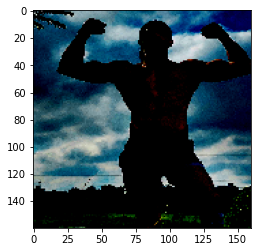

In [22]:

plt.imshow(pic['pic'])

In [23]:
spark = SparkSession.builder.master('local').getOrCreate()

21/10/08 15:45:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [24]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

als.setSeed(0)

hashtag_spark_df = spark.createDataFrame(hashtag_rec_data)
als_model = als.fit(hashtag_spark_df)
# als_model.write().overwrite().save('als')

21/10/08 15:45:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/08 15:45:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/08 15:45:40 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/10/08 15:45:40 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [25]:
als_model

ALSModel: uid=ALS_6b0a78a113ac, rank=10

In [26]:
hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

,image_id,hashtag_id,rating
17447,999,5028,1
17448,999,6570,1
17449,999,5996,1
17450,999,5984,1
17451,999,7760,1


In [27]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()
recs.tail()

,image_id,recommendations
859,208,"[(5173, 1.0170012712478638), (5191, 0.94323128..."
860,401,"[(1096, 1.040050745010376), (757, 0.9642686247..."
861,422,"[(765, 1.0593430995941162), (2019, 1.041527390..."
862,517,"[(1582, 0.8116309642791748), (7239, 0.80281531..."
863,89,"[(7239, 1.5477627515792847), (5173, 1.35765719..."


In [28]:

hashtag_index = list(all_hashtags)
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [29]:
len(recs.index)

864

In [30]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)
recs.index = recs['image_id']
recs = recs.join(hashtag_metadata, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [31]:

recs.drop('recommendations', axis=1, inplace=True)
image_factors = als_model.userFactors.toPandas()
image_factors.index = image_factors['id']
recs.join(image_factors);

In [32]:
recs_deep = recs.join(pics, on='image_local_name', how='inner')
recs_deep.info()
# print(recs_deep.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862 entries, 471 to 89
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   recommended_hashtags  862 non-null    object
 1   hashtags              862 non-null    object
 2   image_local_name      862 non-null    object
 3   search_hashtag        862 non-null    object
 4   pic                   862 non-null    object
 5   hashtag               862 non-null    object
 6   name                  862 non-null    object
 7   deep_features         862 non-null    object
dtypes: object(8)
memory usage: 60.6+ KB


In [33]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

,0
#ARCH,0
#ART,1
#AWPTcoach,2
#Aboutwomens,3
#Admission,4


In [34]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']
hashtags_df.index = hashtags_df['id']
hashtags_df.drop('id', axis=1, inplace=True)
hashtags_df.head()

,hashtag
id,
0,#ARCH
1,#ART
2,#AWPTcoach
3,#Aboutwomens
4,#Admission


In [35]:
img_features = als_model.userFactors.toPandas()
hashtag_features = als_model.itemFactors.toPandas()

In [36]:
recs_deep_clean = recs_deep[['image_local_name', 'hashtags', 'deep_features']]

img_features.index = img_features['id']
img_features.drop(['id'], axis=1)

# Add image feature into dataframe
recommender_df = recs_deep_clean.join(img_features, how='inner')
recommender_df.head()

,image_local_name,hashtags,deep_features,id,features
471,cc6687dc-e2e5-417b-9372-faa5527ed25d.jpg,"[#monsieurbebelife, #Ivorianbaby, #monsieurleb...","[0.2264766, 0.042613965, 0.7752272, 0.3973327,...",471,"[-0.15784144401550293, 0.5163793563842773, -0...."
463,bf96dc78-d4f8-4f35-a2ec-9605803a37c7.jpg,"[#cats, #futuremaman, #birman, #maman, #bebe, ...","[0.0, 1.7325919, 0.12030285, 0.32206786, 0.316...",463,"[-0.057306136935949326, -0.2672276794910431, -..."
833,3b019eed-2e12-4e9a-a49c-ce131257e71e.jpg,"[#pet, #godoxlighting, #portraitphotography, #...","[0.0, 0.0, 0.029408284, 0.0, 0.0, 0.0, 0.0, 0....",833,"[-0.3648046553134918, -0.5840925574302673, 0.5..."
148,08c86967-0dec-45d0-947e-8919b342714b.jpg,"[#nature, #CzechGirl, #BeautyOfNature, #medu, ...","[0.0, 0.47515857, 0.054196358, 0.98798513, 0.4...",148,"[-0.11143600195646286, -0.14699919521808624, 0..."
540,415c35ed-6177-4be1-b6d1-59e689acb1e9.jpg,"[#td, #gqpatrol, #gq, #kettle, #patrol]","[0.0, 0.0, 1.2779106, 0.0, 0.0, 2.1347184, 1.9...",540,"[0.0040685334242880344, -0.0004095354815945029..."


In [37]:
# recommender_df.to_csv('recommender_final.csv')
type(recommender_df['deep_features'][0])

numpy.ndarray

In [38]:
def find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df):
    """Find image features (user vectors) for similar images."""
    prep_image = prepare_image(image_path, where='local')
    pics = extract_features(prep_image, neural_network)
    rdf = recommender_df.copy()
    rdf['dist'] = rdf['deep_features'].apply(lambda x: cosine(x, pics))
    rdf = rdf.sort_values(by='dist')
    return rdf.head(k)

In [39]:
def generate_hashtags(image_path):
    fnv = find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df)
    # Find the average of the 5 user features found based on cosine similarity.
    features = []
    for item in fnv.features.values:
        features.append(item)

    avg_features = np.mean(np.asarray(features), axis=0)
    
    # Add new column to the hashtag features which will be the dot product with the average image(user) features
    hashtag_features['dot_product'] = hashtag_features['features'].apply(lambda x: np.asarray(x).dot(avg_features))

    # Find the 10 hashtags with the highest feature dot products
    final_recs = hashtag_features.sort_values(by='dot_product', ascending=False).head(10)
    # Look up hashtags by their numeric IDs
    output = []
    for hashtag_id in final_recs.id.values:
        output.append(hashtags_df.iloc[hashtag_id]['hashtag'])
    return output

In [40]:
def show_results(test_image):
    img = mpimg.imread(f'test/{test_image}.jpeg')
    plt.figure(figsize=(9, 9))
    plt.title(f'File Name: {test_image.upper()}', fontsize=32)        
    plt.imshow(img)
    
    recommended_hashtags = generate_hashtags(f'test/{test_image}.jpeg')
    print(', '.join(recommended_hashtags))

#nature, #autumn, #naturephotography, #travel, #naturelovers, #travelphotography, #landscape, #landscapephotography, #sky, #naturelover


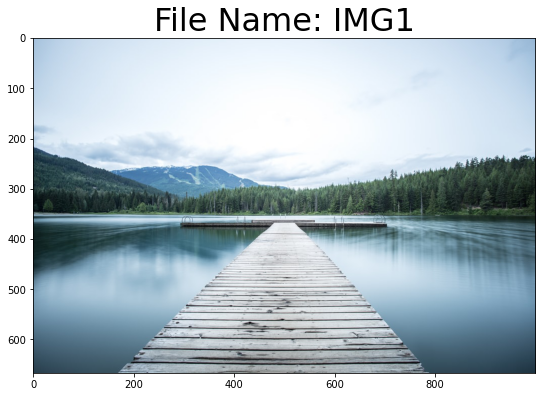

In [40]:
show_results('img1')

#nature, #instagram, #cute, #photooftheday, #love, #animals, #cat, #beautiful, #instagood, #travel


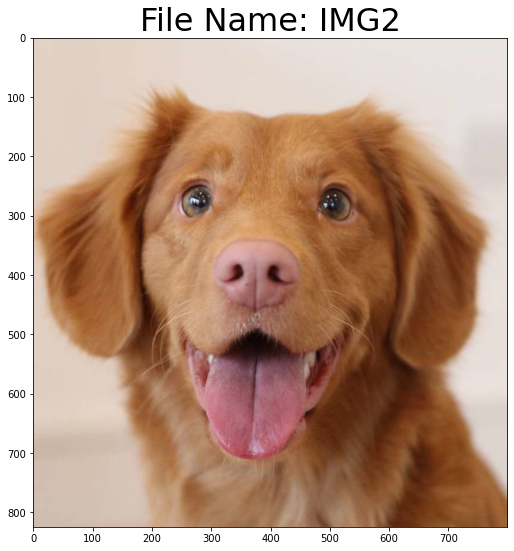

In [41]:
show_results('img2')

#love, #beautiful, #photography, #summer, #photooftheday, #picoftheday, #style, #like, #instadaily, #nature


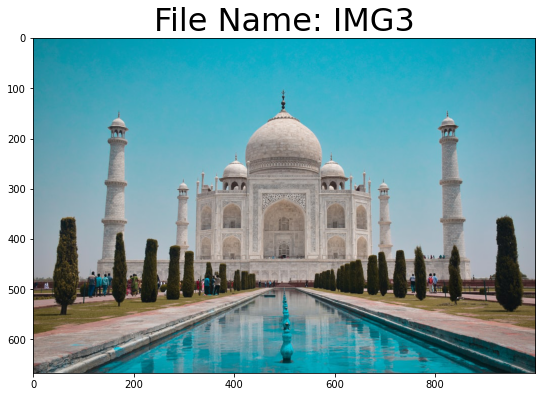

In [42]:
show_results('img3')

#travel, #travelphotography, #nature, #photography, #love, #beautiful, #bhfyp, #landscape, #travelgram, #naturephotography


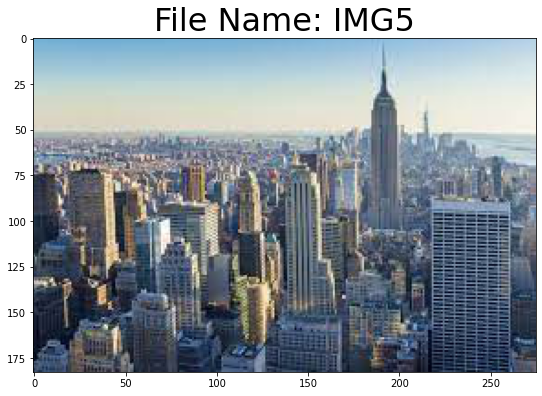

In [43]:
show_results('img5')

#wedding, #like, #weddingphotography, #love, #weddingdress, #fashion, #beautiful, #bride, #summer, #likeforlikes


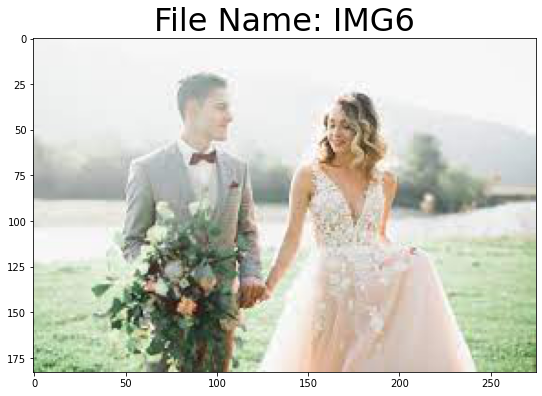

In [44]:
show_results('img6')

#like, #fashion, #wedding, #love, #likeforlikes, #ootd, #beautiful, #beauty, #follow, #instagram


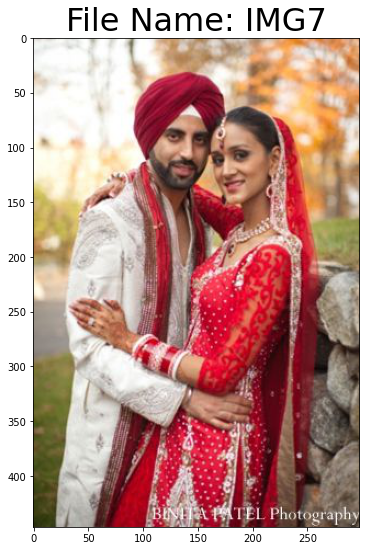

In [45]:
show_results('img7')

#travel, #nature, #travelphotography, #naturephotography, #naturelovers, #instagood, #landscape, #photography, #love, #beautiful


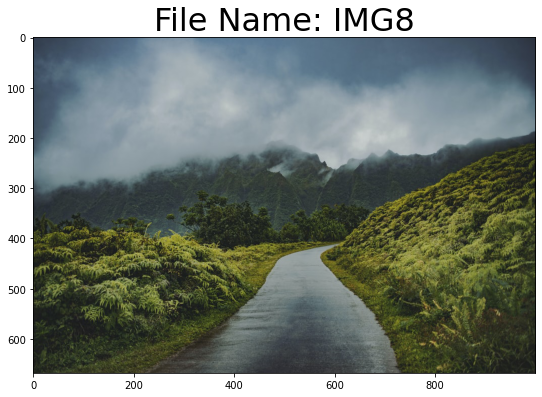

In [46]:
show_results('img8')

#lifestyle, #inspiration, #luxury, #life, #architecture, #design, #happy, #follow, #art, #style


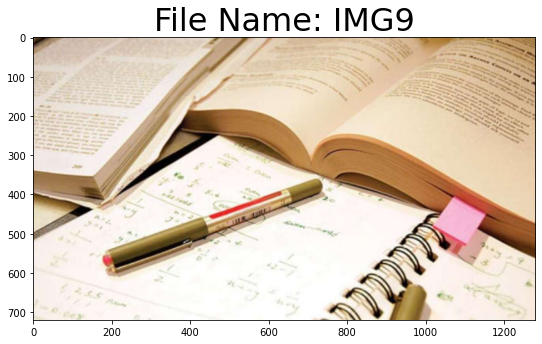

In [47]:
show_results('img9')

In [43]:
# show_results('sample4')

#photography, #like, #love, #fashion, #beautiful, #instagram, #photooftheday, #likeforlikes, #beauty, #instagood


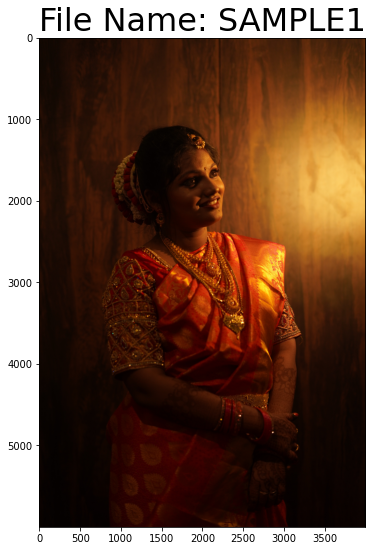

In [42]:
show_results('sample1')